In [3]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
#Import package matplotlib for visualisation/plotting
# import matplotlib.pyplot as plt

# open all the yellow and green taxi file and save them into dataframe

In [ ]:
raw = pd.DataFrame()
combine_raw = pd.DataFrame()
for year in range(2022, 2024):
    for month in range(1, 13):
        if (year == 2023 and month in range (5,13)):
            pass
        else:
            # Make sure the month is two digits        
            month = str(month).zfill(2)
            yellow_file_name = f'yellow_tripdata_{year}-{month}.parquet'
            print(yellow_file_name)

            try:
                raw_yellow_partition = pq.read_table(yellow_file_name)
                raw_yellow_partition = raw_yellow_partition.to_pandas()
    #             [['tpep_pickup_datetime','tpep_dropoff_datetime',
    #                                                     'passenger_count','PULocationID','DOLocationID']]
            except Exception as e:
                    print(f"Could not read file: {yellow_file_name}. Error: {e}")

            green_file_name = f'green_tripdata_{year}-{month}.parquet'
            print(green_file_name)

            try:
                raw_green_partition = pq.read_table(green_file_name)
                raw_green_partition = raw_green_partition.to_pandas()
    #             [['lpep_pickup_datetime','lpep_dropoff_datetime',
    #                                                     'passenger_count','PULocationID','DOLocationID']]

                raw_green_partition.columns = raw_green_partition.columns.str.replace('lpep_pickup_datetime', 'tpep_pickup_datetime')
                raw_green_partition.columns = raw_green_partition.columns.str.replace('lpep_dropoff_datetime', 'tpep_dropoff_datetime')
            except Exception as e:
                    print(f"Could not read file: {green_file_name}. Error: {e}")

            raw = pd.concat([raw,raw_yellow_partition, raw_green_partition],axis=0)
raw.shape

yellow_tripdata_2022-01.parquet
green_tripdata_2022-01.parquet


In [ ]:
raw

# clean duplicated rows

In [ ]:
# clean duplicated rows
print('Number of duplicate (excluding original) rows is:', raw.duplicated().sum())
print('Number of duplicate rows (including first) in the table is:', raw[raw.duplicated(keep=False)].shape[0])
# Show duplicate row data that can be dropped
raw[raw.duplicated(keep=False)]


In [ ]:
raw = raw.drop_duplicates()
print('Number of duplicate (excluding original) rows is:', raw.duplicated().sum())
print('Number of duplicate rows (including first) in the table is:', raw[raw.duplicated(keep=False)].shape[0])

# combine the pickup and dropoff data together

In [5]:
raw_pickup = raw[['tpep_pickup_datetime',
                                            'passenger_count','PULocationID']]
raw_pickup = raw_pickup.set_axis(['datetime', 'passenger_count', 'taxi_zone'], axis='columns')

raw_dropoff = raw[['tpep_dropoff_datetime',
                                            'passenger_count','DOLocationID']]
raw_dropoff = raw_dropoff.set_axis(['datetime', 'passenger_count', 'taxi_zone'], axis='columns')


combine_raw = pd.concat([raw_pickup,raw_dropoff],axis=0)
combine_raw

,datetime,passenger_count,taxi_zone
0,2022-01-01 00:35:40,2.0,142
1,2022-01-01 00:33:43,1.0,236
2,2022-01-01 00:53:21,1.0,166
3,2022-01-01 00:25:21,1.0,114
4,2022-01-01 00:36:48,1.0,68
...,...,...,...
65387,2023-04-30 22:12:00,NaN,168
65388,2023-04-30 23:43:00,NaN,170
65389,2023-04-30 23:40:00,NaN,112
65390,2023-04-30 23:57:00,NaN,236


# check special value for each feature

In [7]:
 # check null value
combine_raw.isnull().sum()

datetime                 0
passenger_count    3607292
taxi_zone                0
dtype: int64

In [8]:
# show date types
combine_raw.dtypes

datetime           datetime64[ns]
passenger_count           float64
taxi_zone                   int64
dtype: object

In [9]:
#update all columns of type 'numeric'
numeric_columns = combine_raw.select_dtypes(['float64']).columns
numeric_columns

Index(['passenger_count'], dtype='object')

In [10]:
# Prepare %missing column
numeric_columns_missing  = 100 * (combine_raw[numeric_columns].isnull().sum()/combine_raw.shape[0])
# store the values in a dataframe
new_df_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])
new_df_numeric_missing

,%missing
passenger_count,3.395688


In [11]:
# Add cardinality column
numeric_columns_card = combine_raw[numeric_columns].nunique()
# store the values in a dataframe
new_df_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])
new_df_numeric_card

,card
passenger_count,10


In [12]:
# Add missing values column
new_df_table_numeric = combine_raw[numeric_columns].describe().T

# Put the columns together to prepare the final table for numeric_columns
# In pandas axis = 0 refers to horizontal axis or rows and axis = 1 refers to vertical axis or columns.
df_numeric_columns_data_quality_report_table = pd.concat([new_df_table_numeric, new_df_numeric_missing, new_df_numeric_card], axis=1)

df_numeric_columns_data_quality_report_table

,count,mean,std,min,25%,50%,75%,max,%missing,card
passenger_count,102624272.0,1.389955,0.947469,0.0,1.0,1.0,1.0,9.0,3.395688,10


In [13]:
# For each continuous feature, we display the range of values it takes.
# We also display the number of instances each of its values has.

for feature in numeric_columns:
    print(feature)
    print("----------\n")
    print("Range {} is: ".format(feature), (combine_raw[feature].max() - combine_raw[feature].min()))
    
    print("----------")
    print('{0:.5}  {1}'.format("Value", "Number of Instances"))
    # nlargest decide how many values show here. the code show top 15 values.
    print(combine_raw[feature].value_counts().nlargest(15), "\n\n\n")

passenger_count
----------

Range passenger_count is:  9.0
----------
Value  Number of Instances
passenger_count
1.0    76388348
2.0    15466896
3.0     3993620
0.0     1964598
4.0     1885114
5.0     1756854
6.0     1167440
7.0         632
8.0         572
9.0         198
Name: count, dtype: int64 





# Extract year and month

In [14]:
# Extract year and month
combine_raw['year_month'] = combine_raw['datetime'].dt.to_period('M')

# Extract day of week (Monday=0, Sunday=6)
combine_raw['day'] = combine_raw['datetime'].dt.day

# Extract day of week (Monday=0, Sunday=6)
combine_raw['week'] = combine_raw['datetime'].dt.dayofweek

# Extract hour of the day
combine_raw['hour'] = combine_raw['datetime'].dt.hour

# days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
# combine_raw['week'] = combine_raw['week'].apply(lambda x: days[x])



In [15]:
combine_raw

,datetime,passenger_count,taxi_zone,year_month,day,week,hour
0,2022-01-01 00:35:40,2.0,142,2022-01,1,5,0
1,2022-01-01 00:33:43,1.0,236,2022-01,1,5,0
2,2022-01-01 00:53:21,1.0,166,2022-01,1,5,0
3,2022-01-01 00:25:21,1.0,114,2022-01,1,5,0
4,2022-01-01 00:36:48,1.0,68,2022-01,1,5,0
...,...,...,...,...,...,...,...
65387,2023-04-30 22:12:00,NaN,168,2023-04,30,6,22
65388,2023-04-30 23:43:00,NaN,170,2023-04,30,6,23
65389,2023-04-30 23:40:00,NaN,112,2023-04,30,6,23
65390,2023-04-30 23:57:00,NaN,236,2023-04,30,6,23


In [16]:
# set categorical types
combine_raw['taxi_zone'] = combine_raw['taxi_zone'].astype('category')
combine_raw['year_month'] = combine_raw['year_month'].astype('category')
combine_raw['day'] = combine_raw['day'].astype('category')
combine_raw['week'] = combine_raw['week'].astype('category')
combine_raw['hour'] = combine_raw['hour'].astype('category')
category_columns = combine_raw.select_dtypes(['category']).columns
category_columns

Index(['taxi_zone', 'year_month', 'day', 'week', 'hour'], dtype='object')

In [17]:
combine_raw[category_columns].describe().T

,count,unique,top,freq
taxi_zone,106231564,263,237,4584018
year_month,106231564,27,2022-10,7443845
day,106231564,31,14,3657504
week,106231564,7,3,16457262
hour,106231564,24,18,7630346


In [18]:
print("taxi_zone: ", combine_raw['taxi_zone'].unique().tolist(), "\n")
print("year_month: ", combine_raw['year_month'].unique().tolist(), "\n")
print("day: ", combine_raw['day'].unique().tolist(), "\n")
print("week: ", combine_raw['week'].unique().tolist(), "\n")
print("hour: ", combine_raw['hour'].unique().tolist(), "\n")

taxi_zone:  [142, 236, 166, 114, 68, 138, 233, 238, 141, 234, 246, 43, 239, 148, 237, 7, 107, 263, 161, 79, 170, 162, 4, 262, 249, 132, 137, 90, 45, 70, 48, 211, 113, 164, 50, 265, 88, 186, 144, 224, 95, 24, 158, 74, 140, 163, 75, 229, 209, 264, 219, 232, 151, 256, 231, 87, 116, 65, 188, 42, 13, 33, 41, 220, 146, 100, 261, 125, 152, 127, 143, 243, 66, 260, 181, 195, 112, 129, 10, 226, 25, 255, 244, 12, 168, 230, 189, 97, 82, 190, 52, 49, 61, 145, 223, 202, 228, 179, 36, 40, 159, 80, 17, 167, 208, 69, 254, 213, 193, 77, 37, 225, 171, 106, 93, 247, 165, 117, 212, 250, 14, 157, 198, 83, 169, 136, 217, 173, 123, 160, 3, 1, 76, 89, 22, 39, 86, 18, 28, 252, 227, 135, 91, 124, 38, 216, 119, 205, 81, 122, 194, 92, 133, 35, 134, 177, 215, 147, 248, 63, 47, 210, 197, 201, 131, 200, 56, 5, 130, 191, 85, 218, 51, 46, 149, 241, 139, 235, 71, 102, 62, 174, 72, 182, 11, 29, 183, 67, 155, 54, 196, 8, 175, 55, 53, 64, 180, 34, 60, 120, 44, 257, 78, 207, 242, 184, 153, 185, 15, 19, 26, 258, 121, 57, 203

In [19]:
for feature in category_columns:
    
    print("----------")
    print('{0:.5}  {1}'.format("Value", "Number of Instances"))
    # nlargest decide how many values show here. the code show top 15 values.
#     print(combine_raw[feature].value_counts().nlargest(15), "\n\n\n")
    print(combine_raw[feature].value_counts().nlargest(250), "\n\n\n")

----------
Value  Number of Instances
taxi_zone
237    4584018
236    4493612
161    4067210
132    3206610
230    3173916
        ...   
251        867
156        813
245        682
172        654
109        614
Name: count, Length: 250, dtype: int64 



----------
Value  Number of Instances
year_month
2022-10    7443845
2022-03    7376674
2022-04    7316875
2022-05    7294463
2022-06    7221825
2023-03    6897255
2022-12    6896177
2023-04    6654896
2022-11    6586270
2022-09    6466728
2022-07    6439575
2022-08    6397156
2023-01    6225586
2022-02    6069670
2023-02    5913524
2022-01    5029155
2023-05        877
2002-10        718
2009-01        130
2008-12         60
2021-12         41
2003-01         28
2001-01         22
2002-12          8
2001-08          2
2014-11          2
2012-02          2
Name: count, dtype: int64 



----------
Value  Number of Instances
day
14    3657504
15    3649686
12    3626068
8     3621002
13    3619171
11    3606078
9     3586193
19    355959

In [20]:
 # check null value
combine_raw.isnull().sum()

datetime                 0
passenger_count    3607292
taxi_zone                0
year_month               0
day                      0
week                     0
hour                     0
dtype: int64

array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

<Figure size 640x480 with 0 Axes>

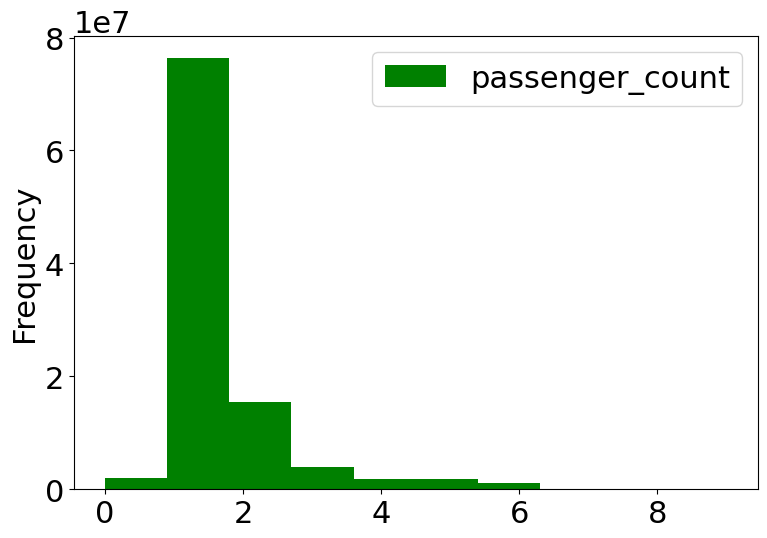

In [21]:
#Plot histograms of the continuous feature case_positive_specimen_interval and case_onset_interval
plt.figure()
plt.rcParams.update({'font.size': 22}) # must set in top
combine_raw[numeric_columns].plot(kind='hist', subplots=True, figsize=(30,20), layout=(3,3), sharex=False, sharey=False, color = 'green')
# plt.savefig('continuous_histograms.pdf')

passenger_count    Axes(0.125,0.77;0.168478x0.11)
dtype: object

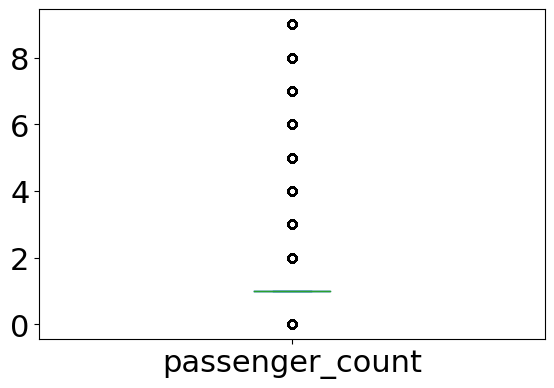

In [22]:
combine_raw[numeric_columns].plot(kind='box', subplots=True, figsize=(30,30), layout=(6,4), sharex=False, sharey=False)
# plt.savefig('continuous_boxplots.pdf')

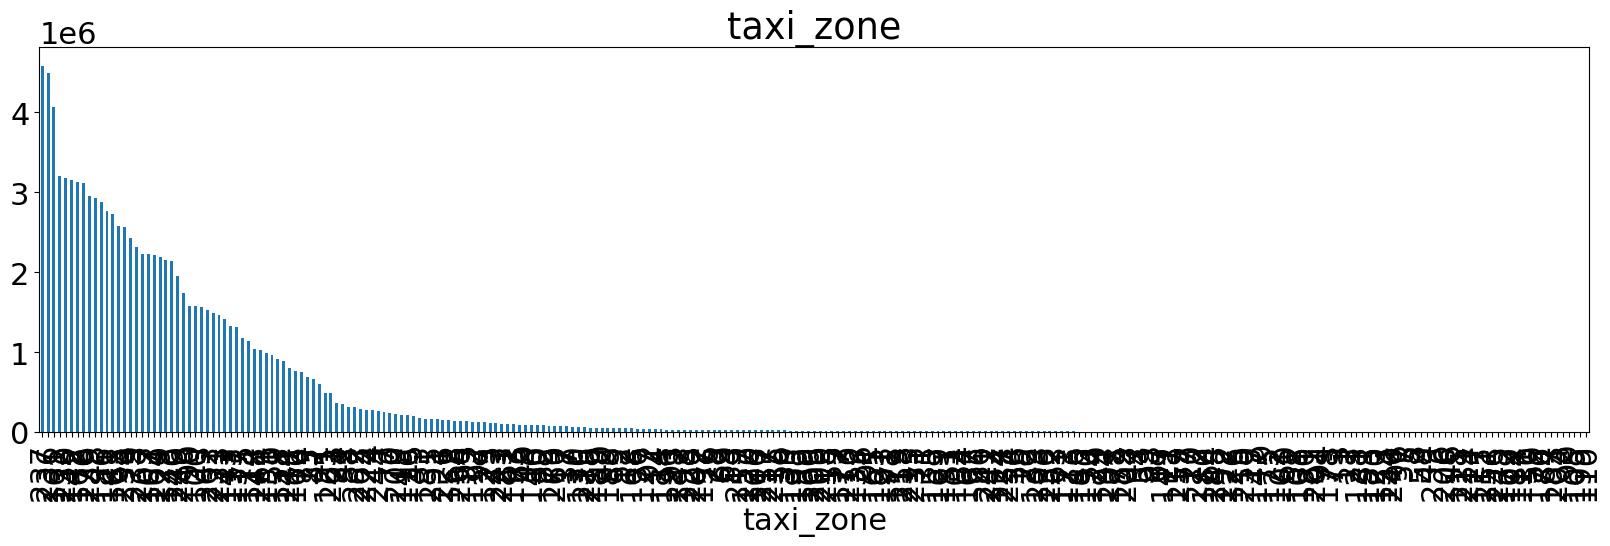

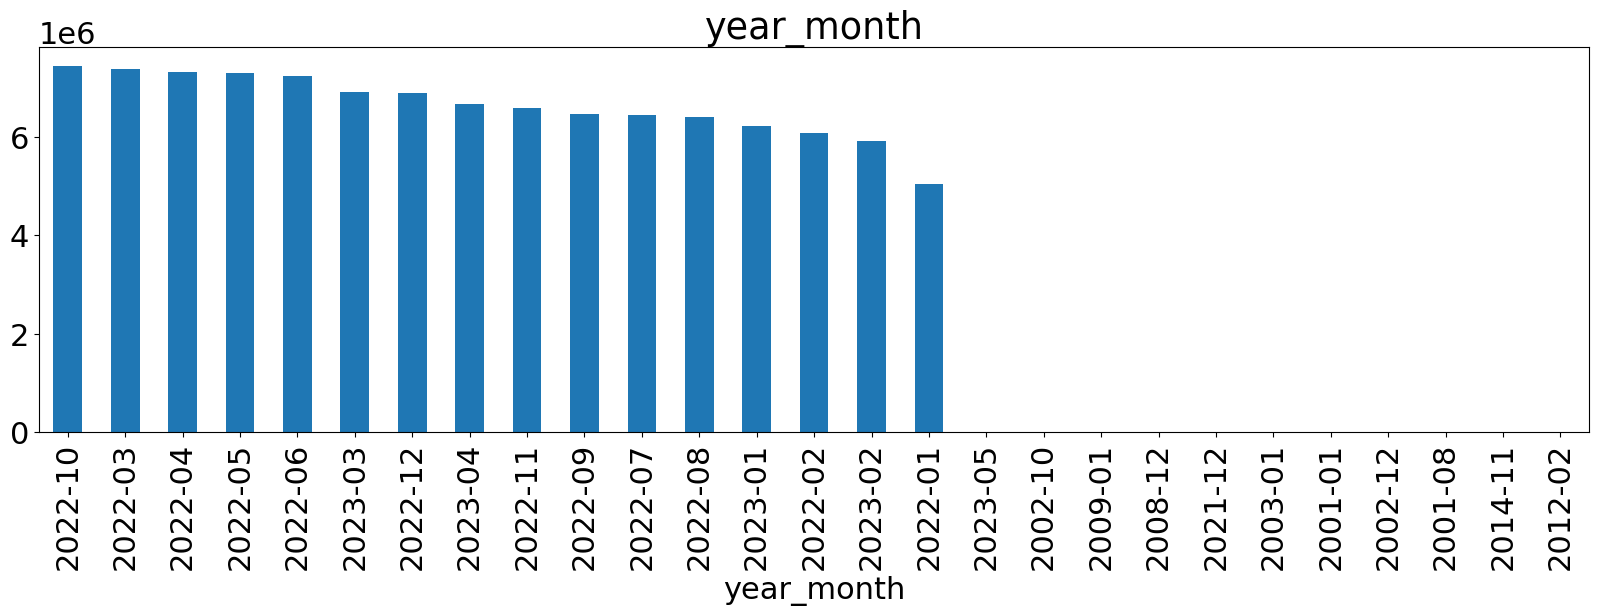

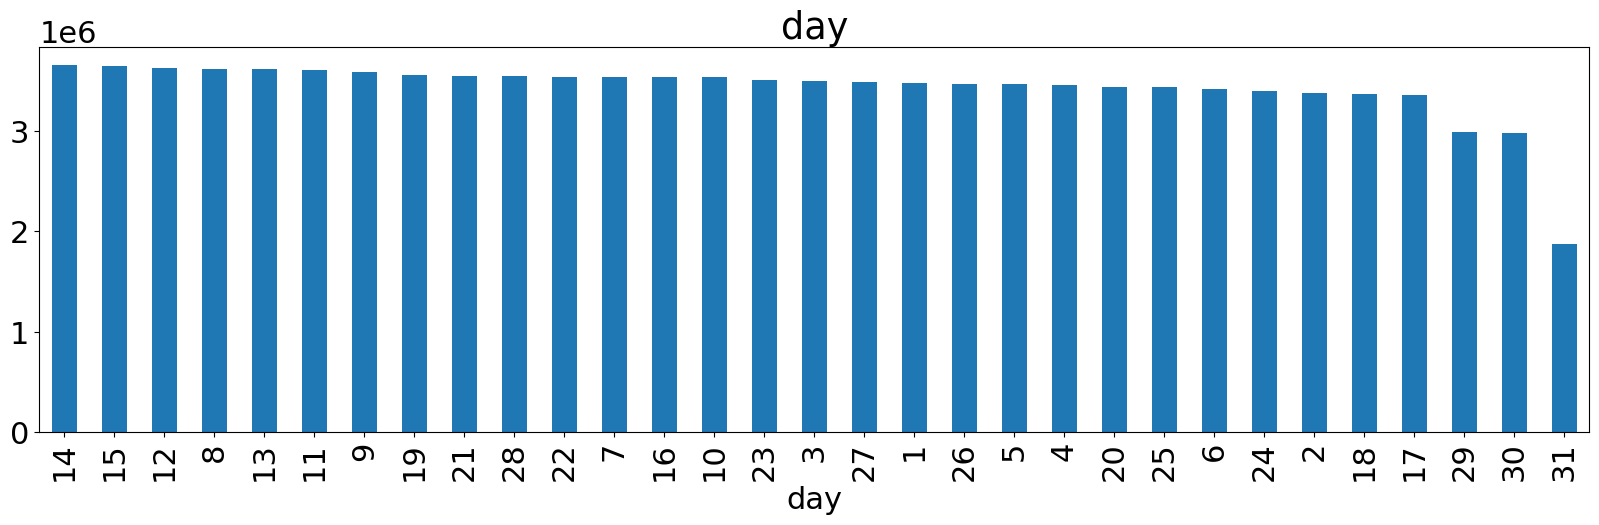

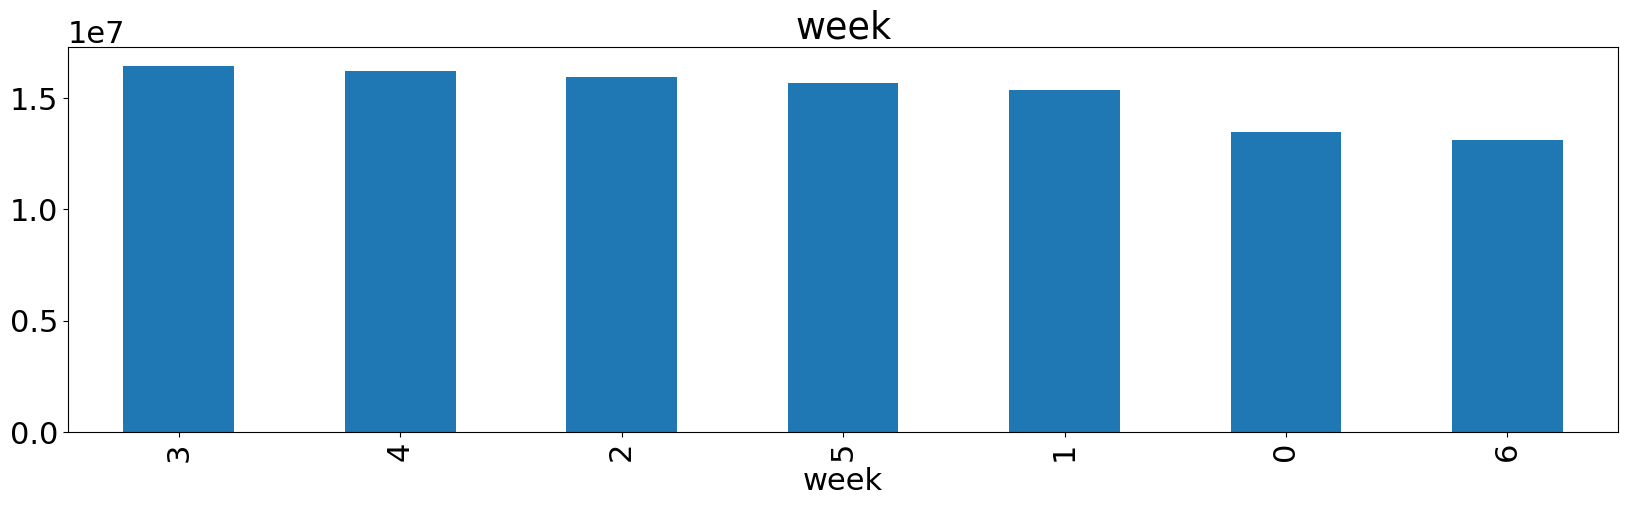

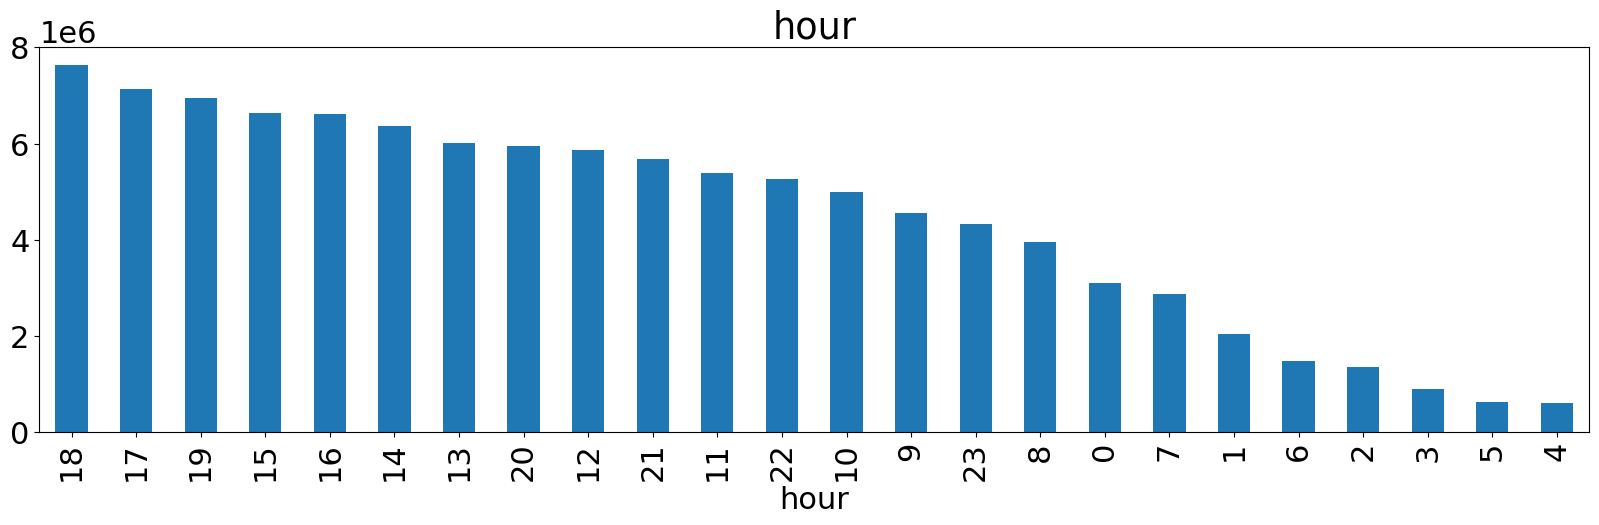

In [23]:
# Plot bar plots for all the catagorical features
for col in category_columns:
    f = combine_raw[col].value_counts().plot(kind='bar', figsize=(20,5))
    plt.title(col)
#         pp.savefig(f.get_figure())
    plt.show()

# replace the null value of passenger_count with median

In [24]:
# replace missing value with reasonable estimate -- median.
median_case_passenger_count = combine_raw['passenger_count'].median()
median_case_passenger_count
combine_raw['passenger_count'] = combine_raw['passenger_count'].replace(np.nan, median_case_passenger_count)

In [25]:
# check the missing value, make sure there is no missing value.
missing_case_passenger_count = combine_raw[combine_raw['passenger_count'].isnull()]
missing_case_passenger_count

,datetime,passenger_count,taxi_zone,year_month,day,week,hour


# replace the "0" value of passenger_count with median

In [26]:
# check the rows of 0 value.
zero_value_case_passenger_count = combine_raw[combine_raw['passenger_count'] == 0]
zero_value_case_passenger_count

,datetime,passenger_count,taxi_zone,year_month,day,week,hour
143,2022-01-01 00:17:34,0.0,236,2022-01,1,5,0
144,2022-01-01 00:23:57,0.0,263,2022-01,1,5,0
145,2022-01-01 00:31:53,0.0,140,2022-01,1,5,0
146,2022-01-01 00:41:40,0.0,163,2022-01,1,5,0
157,2022-01-01 00:55:36,0.0,162,2022-01,1,5,0
...,...,...,...,...,...,...,...
60482,2023-04-30 17:20:44,0.0,65,2023-04,30,6,17
60514,2023-04-30 18:46:26,0.0,238,2023-04,30,6,18
60540,2023-04-30 18:49:55,0.0,97,2023-04,30,6,18
60595,2023-04-30 18:21:29,0.0,52,2023-04,30,6,18


In [27]:
combine_raw['passenger_count'] = combine_raw['passenger_count'].replace(0, median_case_passenger_count)

In [28]:
# check the rows of 0 value has been dropped.
zero_value_case_passenger_count = combine_raw[combine_raw['passenger_count'] == 0]
zero_value_case_passenger_count

,datetime,passenger_count,taxi_zone,year_month,day,week,hour



# clean the rows with wrong month

In [29]:
# check the rows of month can't match.
month_list = ["2023-04", "2023-03", "2023-02", "2023-01", "2022-12", "2022-11","2022-10","2022-9", "2022-8", "2022-7",
             "2022-6","2022-5", "2022-4","2022-3","2022-2","2022-1",]
miss_match_case_month = combine_raw[~combine_raw['year_month'].isin(month_list)]

miss_match_case_month

,datetime,passenger_count,taxi_zone,year_month,day,week,hour
940,2021-12-31 23:52:28,1.0,238,2021-12,31,4,23
1028,2021-12-31 23:59:23,2.0,79,2021-12,31,4,23
1049,2021-12-31 23:57:54,1.0,148,2021-12,31,4,23
1290,2021-12-31 23:57:35,2.0,249,2021-12,31,4,23
1442,2021-12-31 23:58:55,1.0,137,2021-12,31,4,23
...,...,...,...,...,...,...,...
60872,2023-05-01 00:08:25,1.0,75,2023-05,1,0,0
60894,2023-05-01 00:03:12,2.0,260,2023-05,1,0,0
60901,2023-05-01 00:17:14,1.0,67,2023-05,1,0,0
60904,2023-05-01 00:13:02,1.0,73,2023-05,1,0,0


In [30]:
# drop miss match value rows.
combine_raw = combine_raw.drop(miss_match_case_month.index)

In [31]:
# check the rows of month can't match.
miss_match_case_month = combine_raw[~combine_raw['year_month'].isin(month_list)]
miss_match_case_month

,datetime,passenger_count,taxi_zone,year_month,day,week,hour


In [32]:
print("taxi_zone: ", combine_raw['taxi_zone'].unique().tolist(), "\n")
print("year_month: ", combine_raw['year_month'].unique().tolist(), "\n")
print("week: ", combine_raw['week'].unique().tolist(), "\n")
print("hour: ", combine_raw['hour'].unique().tolist(), "\n")
print("day: ", combine_raw['day'].unique().tolist(), "\n")
print("passenger_count: ", combine_raw['passenger_count'].unique().tolist(), "\n")

taxi_zone:  [142, 236, 166, 114, 68, 138, 233, 238, 234, 246, 43, 239, 148, 237, 7, 107, 263, 161, 79, 170, 162, 4, 262, 249, 132, 137, 90, 45, 70, 48, 211, 113, 164, 141, 50, 265, 88, 186, 144, 224, 95, 24, 158, 74, 140, 163, 75, 229, 209, 264, 219, 232, 151, 256, 231, 87, 116, 65, 188, 42, 13, 33, 41, 220, 146, 100, 261, 125, 152, 127, 143, 243, 66, 260, 181, 195, 112, 129, 10, 226, 25, 255, 244, 12, 168, 230, 189, 97, 82, 190, 52, 49, 61, 145, 223, 202, 228, 179, 36, 40, 159, 80, 17, 167, 208, 69, 254, 213, 193, 77, 37, 225, 171, 106, 93, 247, 165, 117, 212, 250, 14, 157, 198, 83, 169, 136, 217, 173, 123, 160, 3, 1, 76, 89, 22, 39, 86, 18, 28, 252, 227, 135, 91, 124, 38, 216, 119, 205, 81, 122, 194, 92, 133, 35, 134, 177, 215, 147, 248, 63, 47, 210, 197, 201, 131, 200, 56, 5, 130, 191, 85, 218, 51, 46, 149, 241, 139, 235, 71, 102, 62, 174, 72, 182, 11, 29, 183, 67, 155, 54, 196, 8, 175, 55, 53, 64, 180, 34, 60, 120, 44, 257, 78, 207, 242, 184, 153, 185, 15, 19, 26, 258, 121, 57, 203

In [33]:
combine_raw.dtypes

datetime           datetime64[ns]
passenger_count           float64
taxi_zone                category
year_month               category
day                      category
week                     category
hour                     category
dtype: object

In [34]:
combine_raw

,datetime,passenger_count,taxi_zone,year_month,day,week,hour
0,2022-01-01 00:35:40,2.0,142,2022-01,1,5,0
1,2022-01-01 00:33:43,1.0,236,2022-01,1,5,0
2,2022-01-01 00:53:21,1.0,166,2022-01,1,5,0
3,2022-01-01 00:25:21,1.0,114,2022-01,1,5,0
4,2022-01-01 00:36:48,1.0,68,2022-01,1,5,0
...,...,...,...,...,...,...,...
65387,2023-04-30 22:12:00,1.0,168,2023-04,30,6,22
65388,2023-04-30 23:43:00,1.0,170,2023-04,30,6,23
65389,2023-04-30 23:40:00,1.0,112,2023-04,30,6,23
65390,2023-04-30 23:57:00,1.0,236,2023-04,30,6,23


# group the passenger number together by the hour

In [35]:
# change the time into hour, ignore the minutes and seconds
combine_raw['datetime'] = combine_raw['datetime'].dt.floor('H')


In [36]:
df_grouped = combine_raw.groupby(['taxi_zone', 'datetime'])['passenger_count'].sum().reset_index()

In [37]:
df_grouped

,taxi_zone,datetime,passenger_count
0,1,2022-01-01 00:00:00,0.0
1,1,2022-01-01 01:00:00,0.0
2,1,2022-01-01 02:00:00,2.0
3,1,2022-01-01 03:00:00,1.0
4,1,2022-01-01 04:00:00,8.0
...,...,...,...
3061315,265,2023-04-30 19:00:00,41.0
3061316,265,2023-04-30 20:00:00,53.0
3061317,265,2023-04-30 21:00:00,45.0
3061318,265,2023-04-30 22:00:00,62.0


In [38]:
# Extract year and month
df_grouped['year_month'] = df_grouped['datetime'].dt.to_period('M')

# Extract day of week (Monday=0, Sunday=6)
# df_grouped['day'] = df_grouped['datetime'].dt.day

# Extract day of week (Monday=0, Sunday=6)
df_grouped['week'] = df_grouped['datetime'].dt.dayofweek

# Extract hour of the day
df_grouped['hour'] = df_grouped['datetime'].dt.hour

# days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
# combine_raw['week'] = combine_raw['week'].apply(lambda x: days[x])

df_grouped

,taxi_zone,datetime,passenger_count,year_month,week,hour
0,1,2022-01-01 00:00:00,0.0,2022-01,5,0
1,1,2022-01-01 01:00:00,0.0,2022-01,5,1
2,1,2022-01-01 02:00:00,2.0,2022-01,5,2
3,1,2022-01-01 03:00:00,1.0,2022-01,5,3
4,1,2022-01-01 04:00:00,8.0,2022-01,5,4
...,...,...,...,...,...,...
3061315,265,2023-04-30 19:00:00,41.0,2023-04,6,19
3061316,265,2023-04-30 20:00:00,53.0,2023-04,6,20
3061317,265,2023-04-30 21:00:00,45.0,2023-04,6,21
3061318,265,2023-04-30 22:00:00,62.0,2023-04,6,22


In [39]:
df_grouped.reset_index(drop=True).to_parquet("basic_taxi_df.parquet", index=False)

In [40]:
df = pd.read_parquet("basic_taxi_df.parquet")
df

,taxi_zone,datetime,passenger_count,year_month,week,hour
0,1,2022-01-01 00:00:00,0.0,2022-01,5,0
1,1,2022-01-01 01:00:00,0.0,2022-01,5,1
2,1,2022-01-01 02:00:00,2.0,2022-01,5,2
3,1,2022-01-01 03:00:00,1.0,2022-01,5,3
4,1,2022-01-01 04:00:00,8.0,2022-01,5,4
...,...,...,...,...,...,...
3061315,265,2023-04-30 19:00:00,41.0,2023-04,6,19
3061316,265,2023-04-30 20:00:00,53.0,2023-04,6,20
3061317,265,2023-04-30 21:00:00,45.0,2023-04,6,21
3061318,265,2023-04-30 22:00:00,62.0,2023-04,6,22
